--- Step 1: File Upload ---
Please upload all FIVE required Excel files as prompted.
----------------------------------------------------------------------

UPLOADING DATA FOR: MAP
-> Please select the file corresponding to 'mapped_dataset_1.xlsx'


Saving mapped_dataset_1.xlsx to mapped_dataset_1 (3).xlsx
-> Successfully uploaded 'mapped_dataset_1 (3).xlsx' for MAP.

UPLOADING DATA FOR: RAND
-> Please select the file corresponding to 'Random_Selection_Report_defaultsize.xlsx'


Saving Random_Selection_Report_defaultsize.xlsx to Random_Selection_Report_defaultsize (2).xlsx
-> Successfully uploaded 'Random_Selection_Report_defaultsize (2).xlsx' for RAND.

UPLOADING DATA FOR: BASELINE
-> Please select the file corresponding to 'BCPSO_Report.xlsx'


Saving BCPSO_Report.xlsx to BCPSO_Report (2).xlsx
-> Successfully uploaded 'BCPSO_Report (2).xlsx' for BASELINE.

UPLOADING DATA FOR: RTSGA
-> Please select the file corresponding to 'RTS-GA-v1-balanced.xlsx'


Saving RTS-GA-v1-balanced.xlsx to RTS-GA-v1-balanced (2).xlsx
-> Successfully uploaded 'RTS-GA-v1-balanced (2).xlsx' for RTSGA.

UPLOADING DATA FOR: RTSGA-HC
-> Please select the file corresponding to 'RTS-GA-v1_balanced.xlsx'


Saving RTS-GA-v1_balanced.xlsx to RTS-GA-v1_balanced (2).xlsx
-> Successfully uploaded 'RTS-GA-v1_balanced (2).xlsx' for RTSGA-HC.

--- Step 2: Data Processing ---
All files uploaded. Starting data processing...
-> Created mapping: 248 requirements mapped to 80 unique test cases.
-> Average TCs per Requirement for estimation: 0.32
-> Processed RAND data.
-> Processed BASELINE (BCPSO) data.
-> Processed RTSGA data.
-> Processed RTSGA-HC data.

All data processed and combined successfully.

--- Step 3: Generating Plots ---

1. Generating the combined plot...


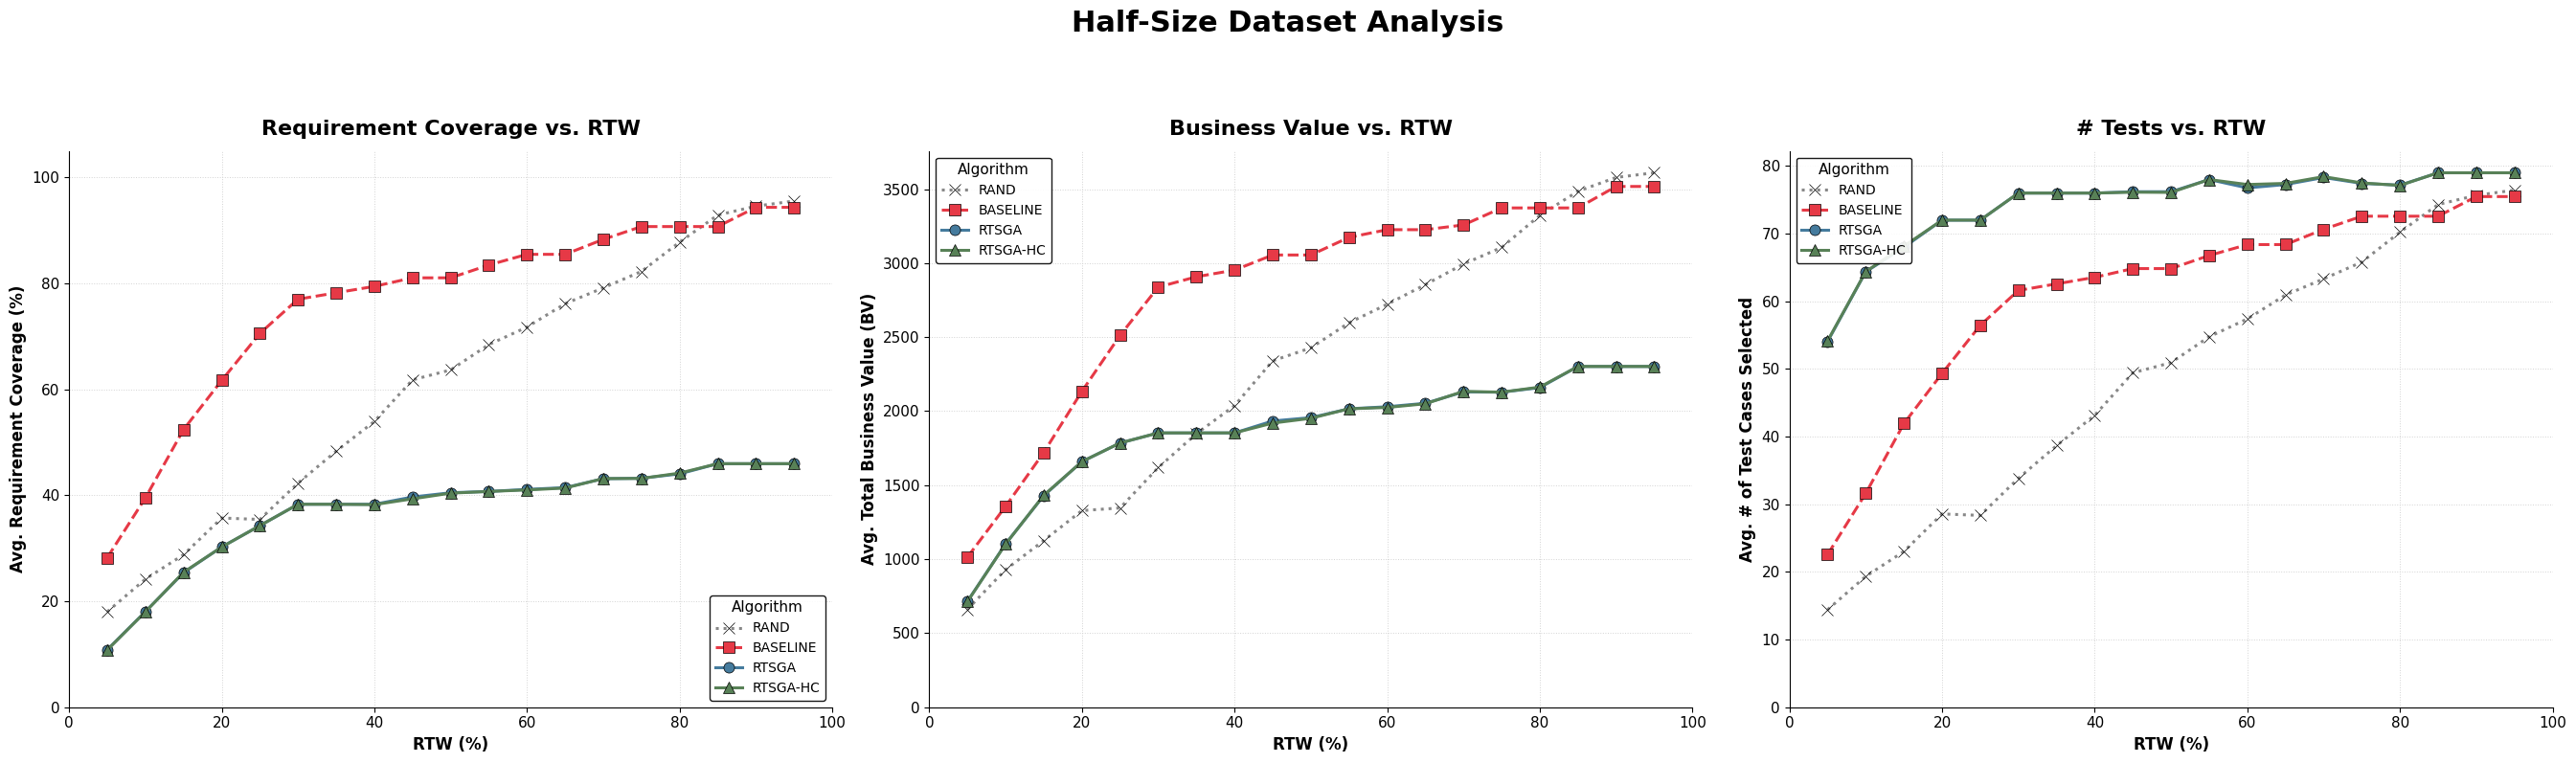

-> Combined plot saved as 'Combined_Comparison_Plot.png'

2. Generating individual plots...


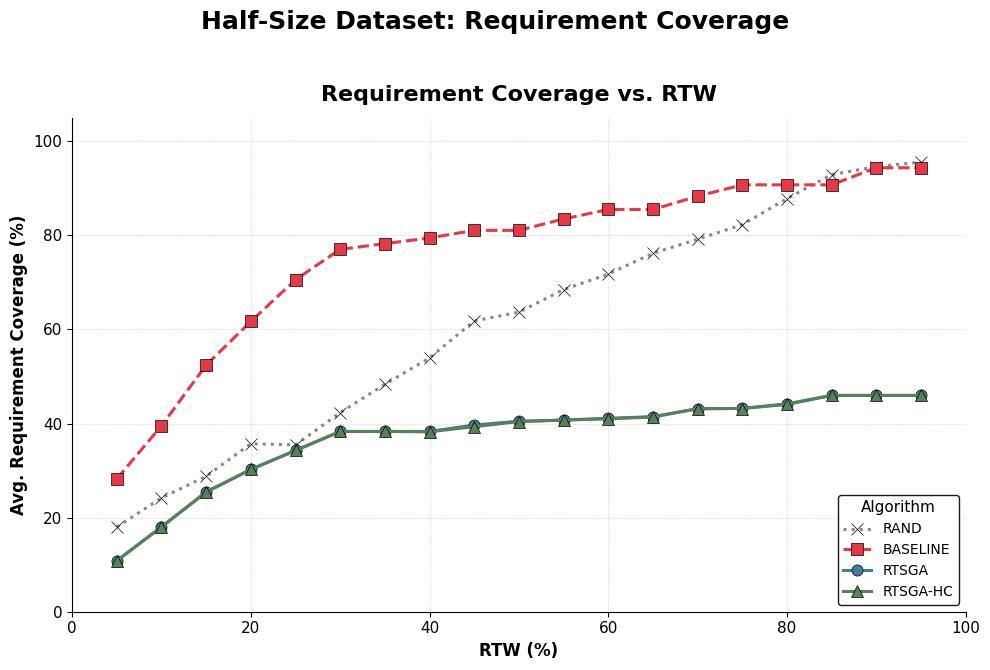

-> Individual plot saved as 'Requirement_Coverage.png'


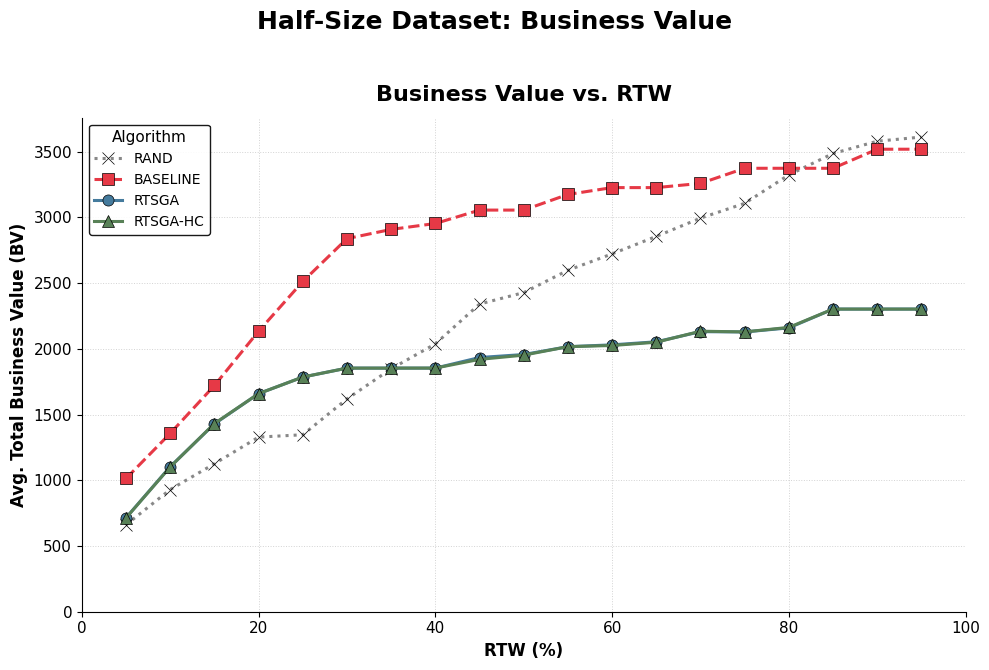

-> Individual plot saved as 'Business_Value.png'


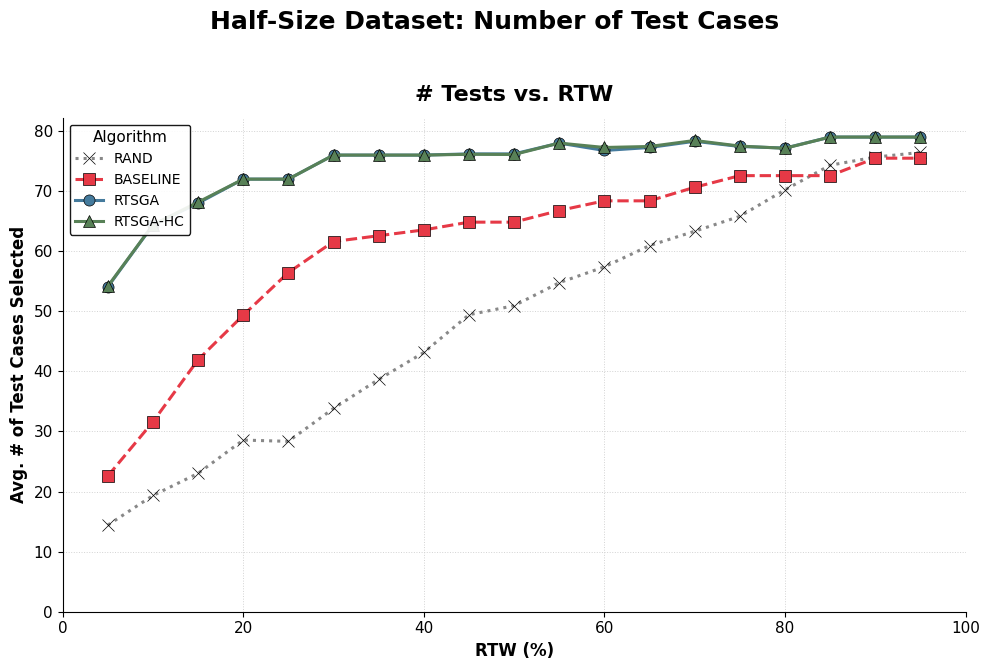

-> Individual plot saved as 'Num_Tests.png'

All plots generated successfully!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import ast  # To safely evaluate string-formatted lists
from google.colab import files


# ==============================================================================
# --- 2. FILE UPLOAD SECTION ---
# ==============================================================================

print("--- Step 1: File Upload ---")
print("Please upload all FIVE required Excel files as prompted.")
print("-" * 70)

# Define the file keys and their expected corresponding filenames
file_map = {
    'MAP': 'mapped_dataset_1.xlsx',
    'RAND': 'Random_Selection_Report_defaultsize.xlsx',
    'BASELINE': 'BCPSO_Report.xlsx',
    'RTSGA': 'RTS-GA-v1-balanced.xlsx',
    'RTSGA-HC': 'RTS-GA-v1_balanced.xlsx' # IMPORTANT: For the script to distinguish the two GA versions,
                                          # please upload your second GA file when prompted for RTSGA-HC.
}

uploaded_files = {}
all_files_valid = True

# Loop through each required file and handle the upload
for key, expected_name in file_map.items():
    print(f"\nUPLOADING DATA FOR: {key}")
    print(f"-> Please select the file corresponding to '{expected_name}'")
    try:
        uploaded = files.upload()
        if not uploaded:
            print("--- CANCELED ---")
            print(f"No file uploaded for {key}. Please re-run the script.")
            all_files_valid = False
            break
        filename = next(iter(uploaded))
        uploaded_files[key] = uploaded[filename]
        print(f"-> Successfully uploaded '{filename}' for {key}.")
    except Exception as e:
        print(f"An unexpected error occurred during upload: {e}")
        all_files_valid = False
        break

# Proceed only if all uploads are successful
if not all_files_valid:
    print("\nFile upload process was interrupted or failed. Please re-run the cell.")
else:
    print("\n" + "=" * 70)
    print("--- Step 2: Data Processing ---")
    print("All files uploaded. Starting data processing...")

    TOTAL_REQUIREMENTS = 248
    all_processed_data = []

    try:
        # --- Create Requirement-to-Test-Case Lookup ---
        df_map = pd.read_excel(io.BytesIO(uploaded_files['MAP']))
        us_to_tc_lookup = df_map.groupby('us_id')['tc_id'].apply(list).to_dict()

        # Calculate the average number of TCs per US for estimation
        total_unique_tcs = df_map['tc_id'].nunique()
        total_unique_uses = df_map['us_id'].nunique()
        avg_tcs_per_us = total_unique_tcs / total_unique_uses

        print(f"-> Created mapping: {total_unique_uses} requirements mapped to {total_unique_tcs} unique test cases.")
        print(f"-> Average TCs per Requirement for estimation: {avg_tcs_per_us:.2f}")

        def get_test_count_from_reqs(req_list_str):
            """Calculates the unique test case count from a string list of requirements."""
            try:
                req_list = ast.literal_eval(req_list_str)
                all_tcs = set()
                for req_id in req_list:
                    if req_id in us_to_tc_lookup:
                        for tc in us_to_tc_lookup[req_id]:
                            all_tcs.add(tc)
                return len(all_tcs)
            except (ValueError, SyntaxError):
                return 0

        # --- Process RAND ---
        df_rand_raw = pd.read_excel(io.BytesIO(uploaded_files['RAND']))
        df_rand = df_rand_raw.groupby('budget_pct').agg(
            coverage=('req_coverage_pct', 'mean'),
            bv=('total_business_value', 'mean')
        ).reset_index()
        num_covered_reqs = (df_rand['coverage'] / 100) * TOTAL_REQUIREMENTS
        df_rand['# Tests'] = num_covered_reqs * avg_tcs_per_us
        df_rand['algorithm'] = 'RAND'
        all_processed_data.append(df_rand)
        print("-> Processed RAND data.")

        # --- Process BASELINE (BCPSO) ---
        df_bcpso_agg = pd.read_excel(io.BytesIO(uploaded_files['BASELINE']), sheet_name=0)
        df_bcpso = df_bcpso_agg[['Time Budget %', 'mean_fully_covered_req_cov', 'mean_fully_covered_bv']].copy()
        df_bcpso.rename(columns={
            'Time Budget %': 'budget_pct', 'mean_fully_covered_req_cov': 'coverage', 'mean_fully_covered_bv': 'bv'
        }, inplace=True)
        num_covered_reqs_bcpso = (df_bcpso['coverage'] / 100) * TOTAL_REQUIREMENTS
        df_bcpso['# Tests'] = num_covered_reqs_bcpso * avg_tcs_per_us
        df_bcpso['algorithm'] = 'BASELINE'
        all_processed_data.append(df_bcpso)
        print("-> Processed BASELINE (BCPSO) data.")

        # --- Process RTSGA ---
        df_rtsga_raw = pd.read_excel(io.BytesIO(uploaded_files['RTSGA']))
        df_rtsga_raw['req_coverage_pct'] = (df_rtsga_raw['num_reqs_covered'] / TOTAL_REQUIREMENTS) * 100
        df_rtsga_raw['# Tests'] = df_rtsga_raw['selected_reqs'].apply(get_test_count_from_reqs)
        df_rtsga = df_rtsga_raw.groupby('budget_pct').agg(
            coverage=('req_coverage_pct', 'mean'),
            bv=('total_business_value', 'mean'),
            tests=('# Tests', 'mean')
        ).reset_index()
        df_rtsga.rename(columns={'tests': '# Tests'}, inplace=True)
        df_rtsga['algorithm'] = 'RTSGA'
        all_processed_data.append(df_rtsga)
        print("-> Processed RTSGA data.")

        # --- Process RTSGA-HC ---
        df_rtshc_raw = pd.read_excel(io.BytesIO(uploaded_files['RTSGA-HC']))
        df_rtshc_raw['req_coverage_pct'] = (df_rtshc_raw['num_reqs_covered'] / TOTAL_REQUIREMENTS) * 100
        df_rtshc_raw['# Tests'] = df_rtshc_raw['selected_reqs'].apply(get_test_count_from_reqs)
        df_rtshc = df_rtshc_raw.groupby('budget_pct').agg(
            coverage=('req_coverage_pct', 'mean'),
            bv=('total_business_value', 'mean'),
            tests=('# Tests', 'mean')
        ).reset_index()
        df_rtshc.rename(columns={'tests': '# Tests'}, inplace=True)
        df_rtshc['algorithm'] = 'RTSGA-HC'
        all_processed_data.append(df_rtshc)
        print("-> Processed RTSGA-HC data.")

        # --- Combine and Finalize DataFrames ---
        combined_df = pd.concat(all_processed_data, ignore_index=True)
        combined_df.rename(columns={
            'budget_pct': 'Time Budget (%)', 'coverage': 'Requirement Coverage (%)', 'bv': 'Business Value'
        }, inplace=True)
        print("\nAll data processed and combined successfully.")

        # ==============================================================================
        # --- 4. PLOTTING SECTION ---
        # ==============================================================================
        print("\n" + "=" * 70)
        print("--- Step 3: Generating Plots ---")

        def plot_on_axis(ax, data, x_col, y_col, title, x_label, y_label, legend_loc='best'):
            styles = {
                'RAND': {'color': '#888888', 'marker': 'x', 'linestyle': ':', 'label': 'RAND'},
                'BASELINE': {'color': '#E63946', 'marker': 's', 'linestyle': '--', 'label': 'BASELINE'},
                'RTSGA': {'color': '#457B9D', 'marker': 'o', 'linestyle': '-', 'label': 'RTSGA'},
                'RTSGA-HC': {'color': '#588157', 'marker': '^', 'linestyle': '-', 'label': 'RTSGA-HC'}
            }
            for algo, style in styles.items():
                subset = data[data['algorithm'] == algo]
                if not subset.empty and not subset[y_col].isnull().all():
                    ax.plot(subset[x_col], subset[y_col],
                            marker=style['marker'], linestyle=style['linestyle'], color=style['color'],
                            label=style['label'], markersize=8, linewidth=2.2,
                            markeredgecolor='black', markeredgewidth=0.5)
            ax.set_title(title, fontsize=16, fontweight='bold', pad=12)
            ax.set_xlabel(x_label, fontsize=12, fontweight='bold')
            ax.set_ylabel(y_label, fontsize=12, fontweight='bold')
            ax.tick_params(axis='both', which='major', labelsize=11)
            ax.set_xlim(0, 100)
            ax.set_ylim(bottom=0)
            if 'Coverage' in y_label: ax.set_ylim(0, 105)
            ax.grid(True, which='major', linestyle=':', linewidth=0.7, color='lightgray')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            legend = ax.legend(title='Algorithm', fontsize=10, title_fontsize=11, loc=legend_loc, frameon=True, fancybox=True)
            legend.get_frame().set_alpha(0.9)
            legend.get_frame().set_edgecolor('black')

        # --- A. Generate and Save Combined Plot ---
        print("\n1. Generating the combined plot...")
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(27, 8))
        fig.suptitle('Half-Size Dataset Analysis', fontsize=22, fontweight='bold', y=1.02)

        plot_on_axis(ax1, combined_df, 'Time Budget (%)', 'Requirement Coverage (%)', 'Requirement Coverage vs. RTW', 'RTW (%)', 'Avg. Requirement Coverage (%)', 'lower right')
        plot_on_axis(ax2, combined_df, 'Time Budget (%)', 'Business Value', 'Business Value vs. RTW', 'RTW (%)', 'Avg. Total Business Value (BV)', 'upper left')
        plot_on_axis(ax3, combined_df, 'Time Budget (%)', '# Tests', '# Tests vs. RTW', 'RTW (%)', 'Avg. # of Test Cases Selected', 'upper left')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("Combined_Comparison_Plot.png", dpi=300, bbox_inches='tight')
        plt.show()
        print("-> Combined plot saved as 'Combined_Comparison_Plot.png'")

        # --- B. Generate and Save Individual Plots ---
        print("\n2. Generating individual plots...")

        # Individual Plot 1: Requirement Coverage
        fig_cov, ax_cov = plt.subplots(figsize=(10, 7))
        plot_on_axis(ax_cov, combined_df, 'Time Budget (%)', 'Requirement Coverage (%)', 'Requirement Coverage vs. RTW', 'RTW (%)', 'Avg. Requirement Coverage (%)', 'lower right')
        fig_cov.suptitle('Half-Size Dataset: Requirement Coverage', fontsize=18, fontweight='bold')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("Requirement_Coverage.png", dpi=300, bbox_inches='tight')
        plt.show()
        print("-> Individual plot saved as 'Requirement_Coverage.png'")

        # Individual Plot 2: Business Value
        fig_bv, ax_bv = plt.subplots(figsize=(10, 7))
        plot_on_axis(ax_bv, combined_df, 'Time Budget (%)', 'Business Value', 'Business Value vs. RTW', 'RTW (%)', 'Avg. Total Business Value (BV)', 'upper left')
        fig_bv.suptitle('Half-Size Dataset: Business Value', fontsize=18, fontweight='bold')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("Business_Value.png", dpi=300, bbox_inches='tight')
        plt.show()
        print("-> Individual plot saved as 'Business_Value.png'")

        # Individual Plot 3: Number of Test Cases
        fig_tests, ax_tests = plt.subplots(figsize=(10, 7))
        plot_on_axis(ax_tests, combined_df, 'Time Budget (%)', '# Tests', '# Tests vs. RTW', 'RTW (%)', 'Avg. # of Test Cases Selected', 'upper left')
        ax_tests.set_ylim(bottom=0) # Ensure Y-axis starts at 0
        fig_tests.suptitle('Half-Size Dataset: Number of Test Cases', fontsize=18, fontweight='bold')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("Num_Tests.png", dpi=300, bbox_inches='tight')
        plt.show()
        print("-> Individual plot saved as 'Num_Tests.png'")

        print("\n" + "=" * 70)
        print("All plots generated successfully!")

    except Exception as e:
        print(f"\n--- AN ERROR OCCURRED ---")
        print(f"Error details: {e}")
        print("Please check the following:")
        print("1. All five files were uploaded correctly.")
        print("2. The Excel files contain the expected column names (e.g., 'budget_pct', 'selected_reqs', etc.).")
        print("3. The 'selected_reqs' column contains valid Python-style lists.")

In [ ]:
import pandas as pd
import io

# ==============================================================================
# --- 0. PRE-FLIGHT CHECK ---
# ==============================================================================
# This script assumes the 'uploaded_files' dictionary from the first cell exists.

if 'uploaded_files' not in locals():
    print("--- ERROR: Files not found! ---")
    print("Please run the first Colab cell to upload all the required data files before running this cell.")
else:
    print("--- Step 1: Calculating Total Possible Business Value ---")

    try:
        # ==============================================================================
        # --- 1. DETERMINE THE MAXIMUM POSSIBLE BUSINESS VALUE (BV) ---
        # ==============================================================================

        # We will scan all uploaded files to find the absolute maximum BV achieved at the 95% budget level.
        # This will serve as our denominator for calculating BV percentages.

        TOTAL_BUSINESS_VALUE = 0

        # Check RAND
        df_rand_temp = pd.read_excel(io.BytesIO(uploaded_files['RAND']))
        TOTAL_BUSINESS_VALUE = max(TOTAL_BUSINESS_VALUE, df_rand_temp[df_rand_temp['budget_pct'] == 95]['total_business_value'].max())

        # Check BCPSO
        df_bcpso_temp = pd.read_excel(io.BytesIO(uploaded_files['BASELINE']), sheet_name=0)
        TOTAL_BUSINESS_VALUE = max(TOTAL_BUSINESS_VALUE, df_bcpso_temp[df_bcpso_temp['Time Budget %'] == 95]['mean_fully_covered_bv'].max())

        # Check RTSGA
        df_rtsga_temp = pd.read_excel(io.BytesIO(uploaded_files['RTSGA']))
        TOTAL_BUSINESS_VALUE = max(TOTAL_BUSINESS_VALUE, df_rtsga_temp[df_rtsga_temp['budget_pct'] == 95]['total_business_value'].max())

        # Check RTSGA-HC
        df_rtshc_temp = pd.read_excel(io.BytesIO(uploaded_files['RTSGA-HC']))
        TOTAL_BUSINESS_VALUE = max(TOTAL_BUSINESS_VALUE, df_rtshc_temp[df_rtshc_temp['budget_pct'] == 95]['total_business_value'].max())

        print(f"-> Total Possible Business Value determined from data: {TOTAL_BUSINESS_VALUE}")
        print("\n" + "=" * 70)
        print("--- Step 2: Processing All Runs to Calculate BV% ---")

        # ==============================================================================
        # --- 2. PROCESS EACH FILE AND GENERATE THE FULL DATASET ---
        # ==============================================================================

        all_runs_data = []

        # Map algorithm keys to their specific BV column names for clarity
        bv_column_map = {
            'RAND': 'total_business_value',
            'RTSGA': 'total_business_value',
            'RTSGA-HC': 'total_business_value',
            'BASELINE': 'mean_fully_covered_bv'
        }

        # --- Process Algorithms with Raw Run Data ---
        for algo_key in ['RAND', 'RTSGA', 'RTSGA-HC']:
            df_raw = pd.read_excel(io.BytesIO(uploaded_files[algo_key]))
            bv_col = bv_column_map[algo_key]

            for row in df_raw.itertuples():
                bv_percentage = (getattr(row, bv_col) / TOTAL_BUSINESS_VALUE) * 100
                all_runs_data.append({
                    'algorithm': algo_key,
                    'budget_pct': row.budget_pct,
                    'run': row.run,
                    'BV%': bv_percentage
                })
            print(f"-> Processed {len(df_raw)} runs for {algo_key}.")

        # --- Process BASELINE (Aggregated Data) ---
        print("\n-> NOTE: BCPSO data is pre-aggregated. Using the mean value as a single representative run for each budget.")
        df_bcpso_agg = pd.read_excel(io.BytesIO(uploaded_files['BASELINE']), sheet_name=0)
        bv_col_bcpso = bv_column_map['BASELINE']

        # Access the column directly from the dataframe to avoid mangled names
        for idx, row in df_bcpso_agg.iterrows():
            budget_pct = row['Time Budget %']  # Access directly using the actual column name
            bv_percentage = (row[bv_col_bcpso] / TOTAL_BUSINESS_VALUE) * 100
            all_runs_data.append({
                'algorithm': 'BASELINE',
                'budget_pct': budget_pct,
                'run': 1,  # Placeholder run number
                'BV%': bv_percentage
            })
        print(f"-> Processed {len(df_bcpso_agg)} aggregated points for BASELINE.")

        # --- Create Final DataFrame ---
        final_bv_df = pd.DataFrame(all_runs_data)

        print("\n" + "=" * 70)
        print("--- Step 3: Displaying Results ---")

        print(f"\nSuccessfully generated a table with {final_bv_df.shape[0]} total data points.")
        print("(Note: Total is not 2280 because the BCPSO file provided aggregated data, not raw run-by-run data.)")

        print("\n--- Full Data Table (Sample Head) ---")
        print(final_bv_df.head(10))

        print("\n--- Full Data Table (Sample Tail) ---")
        print(final_bv_df.tail(10))

        # ==============================================================================
        # --- 4. CREATE PIVOT TABLE FOR VISUALIZATION ---
        # ==============================================================================

        print("\n" + "=" * 70)
        print("--- Step 4: Creating a Summary Pivot Table ---")
        print("This table shows the AVERAGE BV% for each algorithm at each budget level.")

        # Create a pivot table for a summarized view
        summary_pivot_table = final_bv_df.pivot_table(
            index='algorithm',
            columns='budget_pct',
            values='BV%',
            aggfunc='mean'
        )

        # Reorder the index to be more logical
        summary_pivot_table = summary_pivot_table.reindex(['RAND', 'BASELINE', 'RTSGA', 'RTSGA-HC'])

        print(summary_pivot_table.to_string(float_format="%.2f"))

        # ==============================================================================
        # --- 5. DOWNLOAD OPTION ---
        # ==============================================================================

        print("\n" + "=" * 70)
        print("--- Step 5: Download Full Dataset ---")

        # Offer to download the complete, raw dataset as a CSV
        csv_filename = 'all_runs_bv_percentage.csv'
        final_bv_df.to_csv(csv_filename, index=False)

        print(f"The complete dataset with all {final_bv_df.shape[0]} data points has been saved to '{csv_filename}'.")
        print("You can download it from the 'Files' panel on the left side of Colab, or run the cell below.")

        # The files.download call is commented out by default as it can be slow.
        # The user can uncomment it or download from the file explorer.
        # from google.colab import files
        # files.download(csv_filename)

    except KeyError as e:
        print("\n--- AN ERROR OCCURRED: Column Not Found ---")
        print(f"Error details: A column named {e} was not found in one of the files.")
        print("Please verify the column names in your uploaded Excel sheets match the expected names:")
        print("  - BCPSO: 'Time Budget %', 'mean_fully_covered_bv'")
        print("  - RANDOM/RTSGA/RTSGA-HC: 'budget_pct', 'run', 'total_business_value'")

    except Exception as e:
        print(f"\n--- AN UNEXPECTED ERROR OCCURRED ---")
        print(f"Error details: {e}")
        print("Please ensure all files from the first step are still available and have the correct structure.")

--- Step 1: Calculating Total Possible Business Value ---
-> Total Possible Business Value determined from data: 3758

--- Step 2: Processing All Runs to Calculate BV% ---
-> Processed 570 runs for RAND.
-> Processed 570 runs for RTSGA.
-> Processed 570 runs for RTSGA-HC.

-> NOTE: BCPSO data is pre-aggregated. Using the mean value as a single representative run for each budget.
-> Processed 19 aggregated points for BASELINE.

--- Step 3: Displaying Results ---

Successfully generated a table with 1729 total data points.
(Note: Total is not 2280 because the BCPSO file provided aggregated data, not raw run-by-run data.)

--- Full Data Table (Sample Head) ---
  algorithm  budget_pct  run        BV%
0      RAND         5.0    1  17.003725
1      RAND         5.0    2  17.349654
2      RAND         5.0    3  19.558276
3      RAND         5.0    4  21.447578
4      RAND         5.0    5  12.879191
5      RAND         5.0    6  20.649282
6      RAND         5.0    7  14.662054
7      RAND   